In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

project_root = os.path.abspath('..')
sys.path.append(project_root)

from sleeprnn.nn import wave_augment
from sleeprnn.helpers import reader
from sleeprnn.data import utils, stamp_correction
from sleeprnn.detection import metrics
from sleeprnn.common import constants, pkeys, viz

/home/ntapia/miniconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ntapia/miniconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ntapia/miniconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ntapia/miniconda3/envs/tf/lib/python3.6/site-pack

# EEG segment

In [3]:
# Choose segment
subject_id = 1
which_kc_stamp = 195
left_context = 10
right_context = 10

# Load data
dataset = reader.load_dataset(constants.MASS_SS_NAME, verbose=False)
signal = dataset.get_subject_signal(subject_id=subject_id, normalize_clip=False)
stamps_ss = dataset.get_subject_stamps(subject_id=subject_id)
dataset = reader.load_dataset(constants.MASS_KC_NAME, verbose=False)
stamps_kc = dataset.get_subject_stamps(subject_id=subject_id)
fs = dataset.fs
print('%d SS stamps.' % stamps_ss.shape[0])
print('%d KC stamps.' % stamps_kc.shape[0])

# Extract chosen segment
central_sample = stamps_kc[which_kc_stamp, :].mean()
start_sample = int(central_sample - fs * left_context)
end_sample = int(central_sample + fs * right_context)
segment_signal = signal[start_sample:end_sample]
segment_stamps_ss = utils.filter_stamps(stamps_ss, start_sample, end_sample)
segment_stamps_kc = utils.filter_stamps(stamps_kc, start_sample, end_sample)
time_axis = np.arange(start_sample, end_sample) / fs
segment_label_ss = np.zeros(end_sample)
for ss in segment_stamps_ss:
    segment_label_ss[ss[0]:ss[1]+1] = 1
segment_label_ss = segment_label_ss[start_sample:]
print("Segment of %d samples extracted." % segment_signal.size)

# Plotting functions
general_lw = 1.0
signal_lw = 0.6
mark_lw = 3
signal_color = viz.GREY_COLORS[7]
custom_color = viz.PALETTE['red']
ss_color = viz.PALETTE['blue']
kc_color = viz.PALETTE['green']


def draw_signal(
    ax, my_signal, y_min=-120, y_max=120, yticks=[-50, -25, 0, 25, 50], 
    xlabel='Intervals of 1 s', ylabel='EEG ($\mu$V)', 
    linewidth=signal_lw, color=signal_color
):
    ax.plot(time_axis, my_signal, linewidth=linewidth, color=color)
    ax.set_xlabel(xlabel, fontsize=viz.FONTSIZE_GENERAL)
    ax.set_ylabel(ylabel, fontsize=viz.FONTSIZE_GENERAL)
    ax.set_yticks(yticks)
    ax.set_xlim([time_axis[0], time_axis[-1]+0.05])
    ax.set_ylim([y_min, y_max])
    ax.set_xticks([])
    ax.set_xticks(np.arange(time_axis[0], time_axis[-1]+0.1, 1), minor=True)
    ax.grid(b=True, axis='x', which='minor')
    ax.tick_params(labelsize=viz.FONTSIZE_GENERAL)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='x', which='both',length=0)
    return ax
    

def draw_stamps(ax, my_stamps_ss, my_stamps_kc, ss_loc=-60, kc_loc=-70):
    # SS
    label_used = False
    for stamp in my_stamps_ss:
        label = None if label_used else "Sleep Spindle"
        label_used = True
        ax.plot(stamp / fs, [ss_loc, ss_loc], label=label, color=ss_color, linewidth=mark_lw)
    # KC
    label_used = False
    for stamp in my_stamps_kc:
        label = None if label_used else "K-Complex"
        label_used = True
        ax.plot(stamp / fs, [kc_loc, kc_loc], label=label, color=kc_color, linewidth=mark_lw)
    return ax

1044 SS stamps.
409 KC stamps.
Segment of 4000 samples extracted.


## Signals

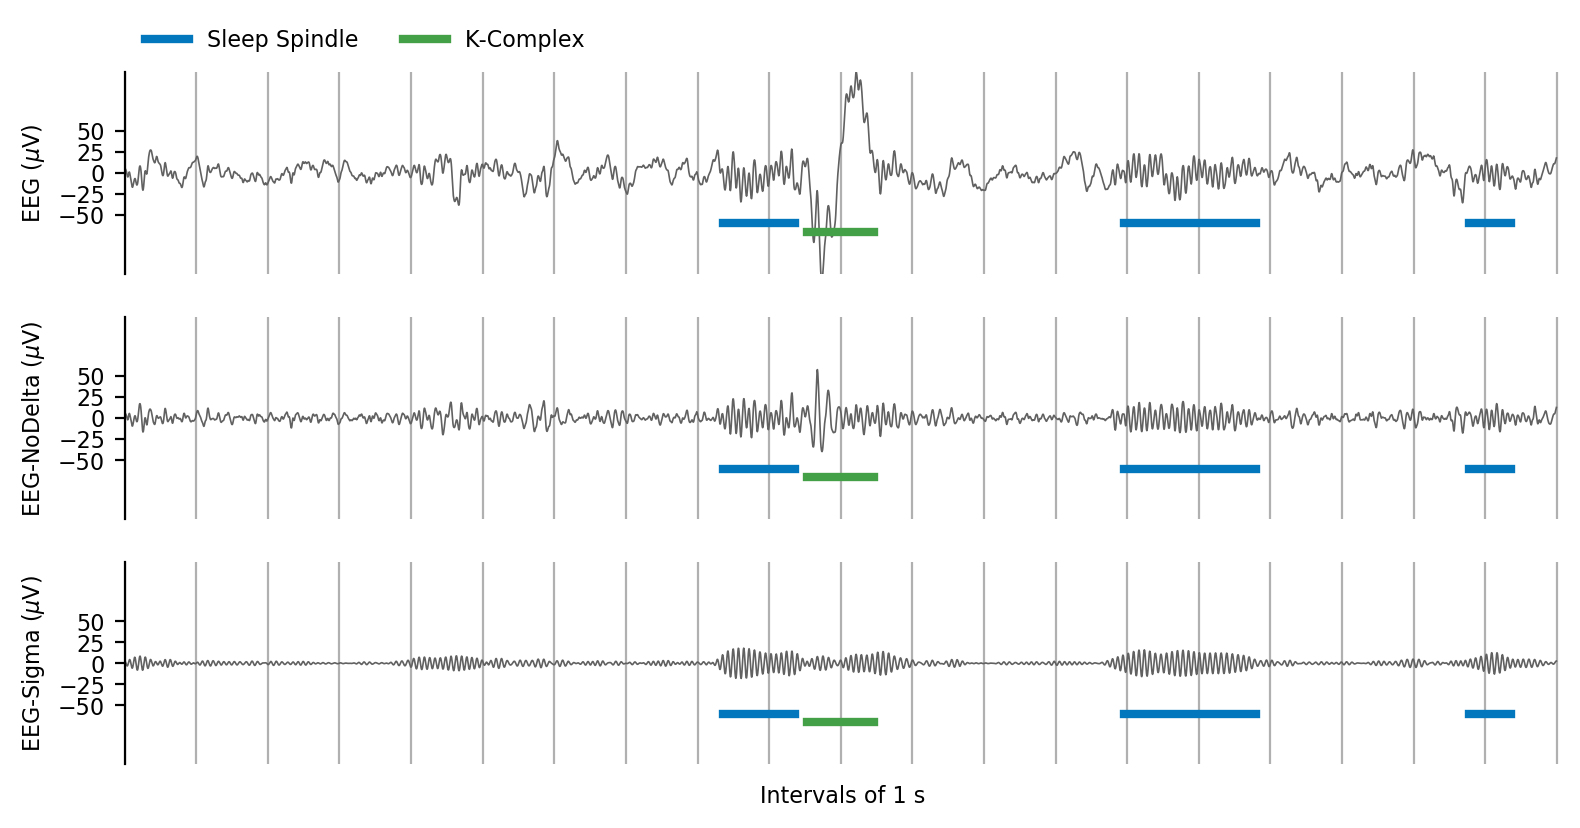

In [13]:
# Filtered signals

# segment_signal is [0.1-35 Hz]


# 4.5 - 30 Hz signal
tf.reset_default_graph()
filt_signal_tf = wave_augment.bandpass_tf(segment_signal, fs, 4.5, None)
with tf.Session() as sess:
    segment_signal_no_delta = sess.run(filt_signal_tf)
    
# 11 - 16 Hz signal
tf.reset_default_graph()
filt_signal_tf = wave_augment.bandpass_tf(segment_signal, fs, 11, 16)
with tf.Session() as sess:
    segment_signal_sigma = sess.run(filt_signal_tf)
    
fig, axes = plt.subplots(3, 1, dpi=200, figsize=(8, 4), sharex=True)

ax = axes[0]
ax = draw_signal(ax, segment_signal, xlabel="")
ax = draw_stamps(ax, segment_stamps_ss, segment_stamps_kc)
ax.legend(loc='lower left', bbox_to_anchor=(0,1), ncol=2, fontsize=viz.FONTSIZE_GENERAL, frameon=False)

ax = axes[1]
ax = draw_signal(ax, segment_signal_no_delta, ylabel="EEG-NoDelta ($\mu$V)", xlabel="")
ax = draw_stamps(ax, segment_stamps_ss, segment_stamps_kc)

ax = axes[2]
ax = draw_signal(ax, segment_signal_sigma, ylabel="EEG-Sigma ($\mu$V)")
ax = draw_stamps(ax, segment_stamps_ss, segment_stamps_kc)

plt.tight_layout()
plt.show()

# A7 features dense replication

In [14]:
def sliding_window_tf(signal, lp_filter_size):
    lp_filter = np.hanning(lp_filter_size).astype(np.float32)
    lp_filter /= lp_filter.sum()
    result = wave_augment.apply_fir_filter_tf(signal, lp_filter)
    return result


def zscore(signal, use_absolute_error=False):
    mean_signal = np.mean(signal)
    signal = signal - mean_signal
    if use_absolute_error:
        std_signal = np.mean(np.abs(signal))
    else:
        std_signal = np.sqrt(np.mean(signal ** 2))
    signal = signal / std_signal
    return signal

## A7absSigPow (exact replica)
By default, it uses log10.

In [ ]:
lp_filter_size = int(fs * 0.3)
squared_sigma = segment_signal_sigma ** 2
tf.reset_default_graph()
filt_signal_tf = sliding_window_tf(squared_sigma, lp_filter_size)
with tf.Session() as sess:
    squared_sigma_smooth = sess.run(filt_signal_tf)
a7_abs_sig_pow = np.log10(squared_sigma_smooth + 1e-4)


fig, axes = plt.subplots(3, 1, dpi=140, figsize=(8, 4.5))

ax = axes[0]
ax = draw_signal(ax, segment_signal)
ax = draw_stamps(ax, segment_stamps_ss, segment_stamps_kc)
ax.legend(loc='lower left', bbox_to_anchor=(0,1), ncol=2, fontsize=viz.FONTSIZE_GENERAL, frameon=False)

ax = axes[1]
y_min = 0
y_max = squared_sigma_smooth.max()
ax = draw_signal(ax, squared_sigma_smooth, y_min=y_min, y_max=y_max, yticks=[0, 100], ylabel="($\mu$V$^2$)")
ax = draw_stamps(ax, segment_stamps_ss, segment_stamps_kc)

ax = axes[2]
y_max = np.abs(a7_abs_sig_pow).max()
y_min = -y_max
ax = draw_signal(ax, a7_abs_sig_pow, y_min=y_min, y_max=y_max, yticks=[-1, 0, 1], ylabel="A7absSigPow")
ax = draw_stamps(ax, segment_stamps_ss, segment_stamps_kc)

plt.tight_layout()
plt.show()

## A7relSigPow (aprox)
By default, it removes delta band from broad EEG. It uses log10 and zscore(10-90th, 30s).

In [ ]:
lp_filter_size = int(fs * 0.5)

# Sigma power
squared_sigma = segment_signal_sigma ** 2
tf.reset_default_graph()
filt_signal_tf = sliding_window_tf(squared_sigma, lp_filter_size)
with tf.Session() as sess:
    squared_sigma_smooth = sess.run(filt_signal_tf)
    
# Broad power
squared_broad = segment_signal_no_delta ** 2
tf.reset_default_graph()
filt_signal_tf = sliding_window_tf(squared_broad, lp_filter_size)
with tf.Session() as sess:
    squared_broad_smooth = sess.run(filt_signal_tf)

# Compute power ratio
rel_pow = squared_sigma_smooth / (squared_broad_smooth + 1e-6)
a7_rel_sig_pow = np.log10(rel_pow + 1e-4)
a7_rel_sig_pow = zscore(a7_rel_sig_pow, use_absolute_error=False)


fig, axes = plt.subplots(3, 1, dpi=140, figsize=(8, 4.5))

ax = axes[0]
ax = draw_signal(ax, segment_signal)
ax = draw_stamps(ax, segment_stamps_ss, segment_stamps_kc)
ax.legend(loc='lower left', bbox_to_anchor=(0,1), ncol=2, fontsize=viz.FONTSIZE_GENERAL, frameon=False)

ax = axes[1]
y_min = 0
y_max = rel_pow.max()
ax = draw_signal(ax, rel_pow, y_min=y_min, y_max=y_max, yticks=[0, 1], ylabel="Ratio")
ax = draw_stamps(ax, segment_stamps_ss, segment_stamps_kc)

ax = axes[2]
y_max = np.abs(a7_rel_sig_pow).max()
y_min = -y_max
ax = draw_signal(ax, a7_rel_sig_pow, y_min=y_min, y_max=y_max, yticks=[-1, 0, 1], ylabel="A7relSigPow")
ax = draw_stamps(ax, segment_stamps_ss, segment_stamps_kc)

plt.tight_layout()
plt.show()

## A7sigmaCov (exact replica)
By default, it uses broad EEG without removing delta band. It uses log10 and zscore(10-90th, 30s). The negative values of the covariance are set to zero, and they do log10(cov + 1) (they add "1").

In [ ]:
lp_filter_size = int(fs * 0.3)

sigma_centered = segment_signal_sigma - np.mean(segment_signal_sigma)
broad_centered = segment_signal - np.mean(segment_signal)


# Covariance
sigma_broad_product = sigma_centered * broad_centered
tf.reset_default_graph()
filt_signal_tf = sliding_window_tf(sigma_broad_product, lp_filter_size)
with tf.Session() as sess:
    cov_smooth = sess.run(filt_signal_tf)
cov_smooth_noneg = np.clip(cov_smooth, a_min=0, a_max=None)  # No negatives, like ReLU
    
a7_sigma_cov = np.log10(cov_smooth_noneg + 1)  # add one to avoid log10(0) = -inf
a7_sigma_cov = zscore(a7_sigma_cov, use_absolute_error=False)


fig, axes = plt.subplots(3, 1, dpi=140, figsize=(8, 4.5))

ax = axes[0]
ax = draw_signal(ax, segment_signal)
ax = draw_stamps(ax, segment_stamps_ss, segment_stamps_kc)
ax.legend(loc='lower left', bbox_to_anchor=(0,1), ncol=2, fontsize=viz.FONTSIZE_GENERAL, frameon=False)

ax = axes[1]
y_max = np.abs(cov_smooth_noneg).max()
y_min = -y_max
ax = draw_signal(ax, cov_smooth_noneg, y_min=y_min, y_max=y_max, yticks=[0], ylabel="CovNoNeg")
ax = draw_stamps(ax, segment_stamps_ss, segment_stamps_kc)

ax = axes[2]
y_max = np.abs(a7_sigma_cov).max()
y_min = -y_max
ax = draw_signal(ax, a7_sigma_cov, y_min=y_min, y_max=y_max, yticks=[-1, 0, 1], ylabel="A7sigmaCov")
ax = draw_stamps(ax, segment_stamps_ss, segment_stamps_kc)

plt.tight_layout()
plt.show()

## A7sigmaCorr (exact replica)
By default, it uses broad EEG without removing delta band. It uses neither log10 nor zscore. 

In [ ]:
lp_filter_size = int(fs * 0.5)

# Most of these calculations should be reused from previous steps 
# when integrating the four parameters

sigma_centered = segment_signal_sigma - np.mean(segment_signal_sigma)
broad_centered = segment_signal - np.mean(segment_signal)

# Covariance
sigma_broad_product = sigma_centered * broad_centered
tf.reset_default_graph()
filt_signal_tf = sliding_window_tf(sigma_broad_product, lp_filter_size)
with tf.Session() as sess:
    cov_smooth = sess.run(filt_signal_tf)

# Standard deviation sigma
sigma_centered_squared = sigma_centered ** 2
tf.reset_default_graph()
filt_signal_tf = sliding_window_tf(sigma_centered_squared, lp_filter_size)
with tf.Session() as sess:
    sigma_var = sess.run(filt_signal_tf)
sigma_std = np.sqrt(sigma_var)

# Standard deviation broad
broad_centered_squared = broad_centered ** 2
tf.reset_default_graph()
filt_signal_tf = sliding_window_tf(broad_centered_squared, lp_filter_size)
with tf.Session() as sess:
    broad_var = sess.run(filt_signal_tf)
broad_std = np.sqrt(broad_var)
    
a7_sigma_corr = cov_smooth / (sigma_std * broad_std + 1e-4)


fig, axes = plt.subplots(3, 1, dpi=140, figsize=(8, 4.5))

ax = axes[0]
ax = draw_signal(ax, segment_signal)
ax = draw_stamps(ax, segment_stamps_ss, segment_stamps_kc)
ax.legend(loc='lower left', bbox_to_anchor=(0,1), ncol=2, fontsize=viz.FONTSIZE_GENERAL, frameon=False)

ax = axes[1]
y_max = np.abs(a7_sigma_cov).max()
y_min = -y_max
ax = draw_signal(ax, a7_sigma_cov, y_min=y_min, y_max=y_max, yticks=[-1, 0, 1], ylabel="A7sigmaCov")
ax = draw_stamps(ax, segment_stamps_ss, segment_stamps_kc)

ax = axes[2]
y_max = +1#np.abs(a7_sigma_corr).max()
y_min = -1#-y_max
ax = draw_signal(ax, a7_sigma_corr, y_min=y_min, y_max=y_max, yticks=[-1, 0, 1], ylabel="A7sigmaCorr")
ax = draw_stamps(ax, segment_stamps_ss, segment_stamps_kc)

plt.tight_layout()
plt.show()

# A7 computation integration (layer)

In [15]:
from scipy.signal import firwin


def apply_fir_filter_tf_batch(signals, kernel):
    """For batch of signals"""
    signals = signals[:, tf.newaxis, :, tf.newaxis]
    kernel = tf.reshape(kernel, shape=[1, -1, 1, 1])
    new_signals = tf.nn.conv2d(
        input=signals, filter=kernel, strides=[1, 1, 1, 1], padding="SAME")
    new_signals = new_signals[:, 0, :, 0]
    return new_signals


def lowpass_tf_batch(signals, fs, cutoff, filter_duration_ref=6, wave_expansion_factor=0.5):
    numtaps = fs * filter_duration_ref / (cutoff ** wave_expansion_factor)
    numtaps = int(2 * (numtaps // 2) + 1)  # ensure odd numtaps
    lp_kernel = firwin(numtaps, cutoff=cutoff, window="hamming", fs=fs).astype(np.float32)
    lp_kernel /= lp_kernel.sum()
    new_signals = apply_fir_filter_tf_batch(signals, lp_kernel)
    return new_signals


def highpass_tf_batch(signals, fs, cutoff, filter_duration_ref=6, wave_expansion_factor=0.5):
    numtaps = fs * filter_duration_ref / (cutoff ** wave_expansion_factor)
    numtaps = int(2 * (numtaps // 2) + 1)  # ensure odd numtaps
    lp_kernel = firwin(numtaps, cutoff=cutoff, window="hamming", fs=fs).astype(np.float32)
    lp_kernel /= lp_kernel.sum()
    # HP = delta - LP
    hp_kernel = -lp_kernel
    hp_kernel[numtaps//2] += 1
    new_signals = apply_fir_filter_tf_batch(signals, hp_kernel)
    return new_signals


def bandpass_tf_batch(signals, fs, lowcut, highcut, filter_duration_ref=6, wave_expansion_factor=0.5):
    new_signals = signals
    if lowcut is not None:
        new_signals = highpass_tf_batch(
            new_signals, fs, lowcut, filter_duration_ref, wave_expansion_factor)
    if highcut is not None:
        new_signals = lowpass_tf_batch(
            new_signals, fs, highcut, filter_duration_ref, wave_expansion_factor)
    return new_signals


def moving_average_tf(signals, lp_filter_size):
    lp_filter = np.hanning(lp_filter_size).astype(np.float32)
    lp_filter /= lp_filter.sum()
    results = apply_fir_filter_tf_batch(signals, lp_filter)
    return results


def zscore_tf(signals, dispersion_mode="std"):
    mean_signals = tf.reduce_mean(signals, axis=1)
    signals = signals - mean_signals
    if dispersion_mode == "made":
        std_signals = tf.reduce_mean(tf.math.abs(signals), axis=1)
    elif dispersion_mode == "std":
        std_signals = tf.math.sqrt(tf.reduce_mean(signals ** 2, axis=1))
    else:
        raise ValueError()
    signals = signals / std_signals
    return signals


def log10_tf(x):
    numerator = tf.log(x)
    denominator = tf.log(tf.constant(10, dtype=numerator.dtype))
    return numerator / denominator


def a7_layer_tf(
    signals,
    fs,
    window_duration=0.5,
    sigma_lowcut=11,
    sigma_highcut=16,
    use_log_absSigPow=True,
    use_log_relSigPow=True,
    use_log_sigCov=True,
    use_zscore_relSigPow=True,
    use_zscore_sigCov=True,
    use_zscore_sigCorr=False,
    dispersion_mode="std"
):
    lp_filter_size = int(fs * window_duration)
    print("Moving window: Using %1.2f s (%d samples)"% (window_duration, lp_filter_size))
    print("Z-score using %s" % dispersion_mode)
    
    signal_sigma = bandpass_tf_batch(signals, fs, sigma_lowcut, sigma_highcut)
    signal_no_delta = bandpass_tf_batch(signals, fs, 4.5, None)
    
    # absolute sigma power
    signal_sigma_squared = signal_sigma ** 2
    abs_sig_pow_raw = moving_average_tf(signal_sigma_squared, lp_filter_size)
    if use_log_absSigPow:
        abs_sig_pow = log10_tf(abs_sig_pow_raw + 1e-4)
        print("absSigPow: Using log10.")
    else:
        abs_sig_pow = abs_sig_pow_raw
    
    # relative sigma power
    signal_no_delta_squared = signal_no_delta ** 2
    abs_no_delta_pow_raw = moving_average_tf(signal_no_delta_squared, lp_filter_size)
    rel_sig_pow_raw = abs_sig_pow_raw / (abs_no_delta_pow_raw + 1e-6)
    if use_log_relSigPow:
        rel_sig_pow = log10_tf(rel_sig_pow_raw + 1e-4)
        print("relSigPow: Using log10.")
    else:
        rel_sig_pow = rel_sig_pow_raw
    if use_zscore_relSigPow:
        rel_sig_pow = zscore_tf(rel_sig_pow, dispersion_mode)
        print("relSigPow: Using z-score.")
    
    # sigma covariance
    sigma_centered = signal_sigma - tf.reduce_mean(signal_sigma, axis=1)
    broad_centered = signals - tf.reduce_mean(signals, axis=1)
    sig_cov_raw = moving_average_tf(sigma_centered * broad_centered, lp_filter_size)
    sig_cov = tf.nn.relu(sig_cov_raw) # no negatives
    if use_log_sigCov:
        sig_cov = log10_tf(sig_cov + 1)  # Add 1
        print("sigCov: Using log10(x+1).")
    if use_zscore_sigCov:
        sig_cov = zscore_tf(sig_cov, dispersion_mode)
        print("sigCov: Using z-score.")
    
    # sigma correlation   
    sig_var_raw = moving_average_tf(sigma_centered ** 2, lp_filter_size)
    broad_var_raw = moving_average_tf(broad_centered ** 2, lp_filter_size)
    sig_std_raw = tf.math.sqrt(sig_var_raw)
    broad_stf_raw = tf.math.sqrt(broad_var_raw)    
    sig_corr = sig_cov_raw / (sig_std_raw * broad_stf_raw + 1e-4)
    if use_zscore_sigCorr:
        sig_corr = zscore_tf(sig_corr, dispersion_mode)
        print("sigCorr: Using z-score.")
    
    a7_parameters = tf.stack([abs_sig_pow, rel_sig_pow, sig_cov, sig_corr], axis=2)
    return a7_parameters

Moving window: Using 0.50 s (100 samples)
Z-score using std
absSigPow: Using log10.
relSigPow: Using log10.
relSigPow: Using z-score.
sigCov: Using log10(x+1).
sigCov: Using z-score.


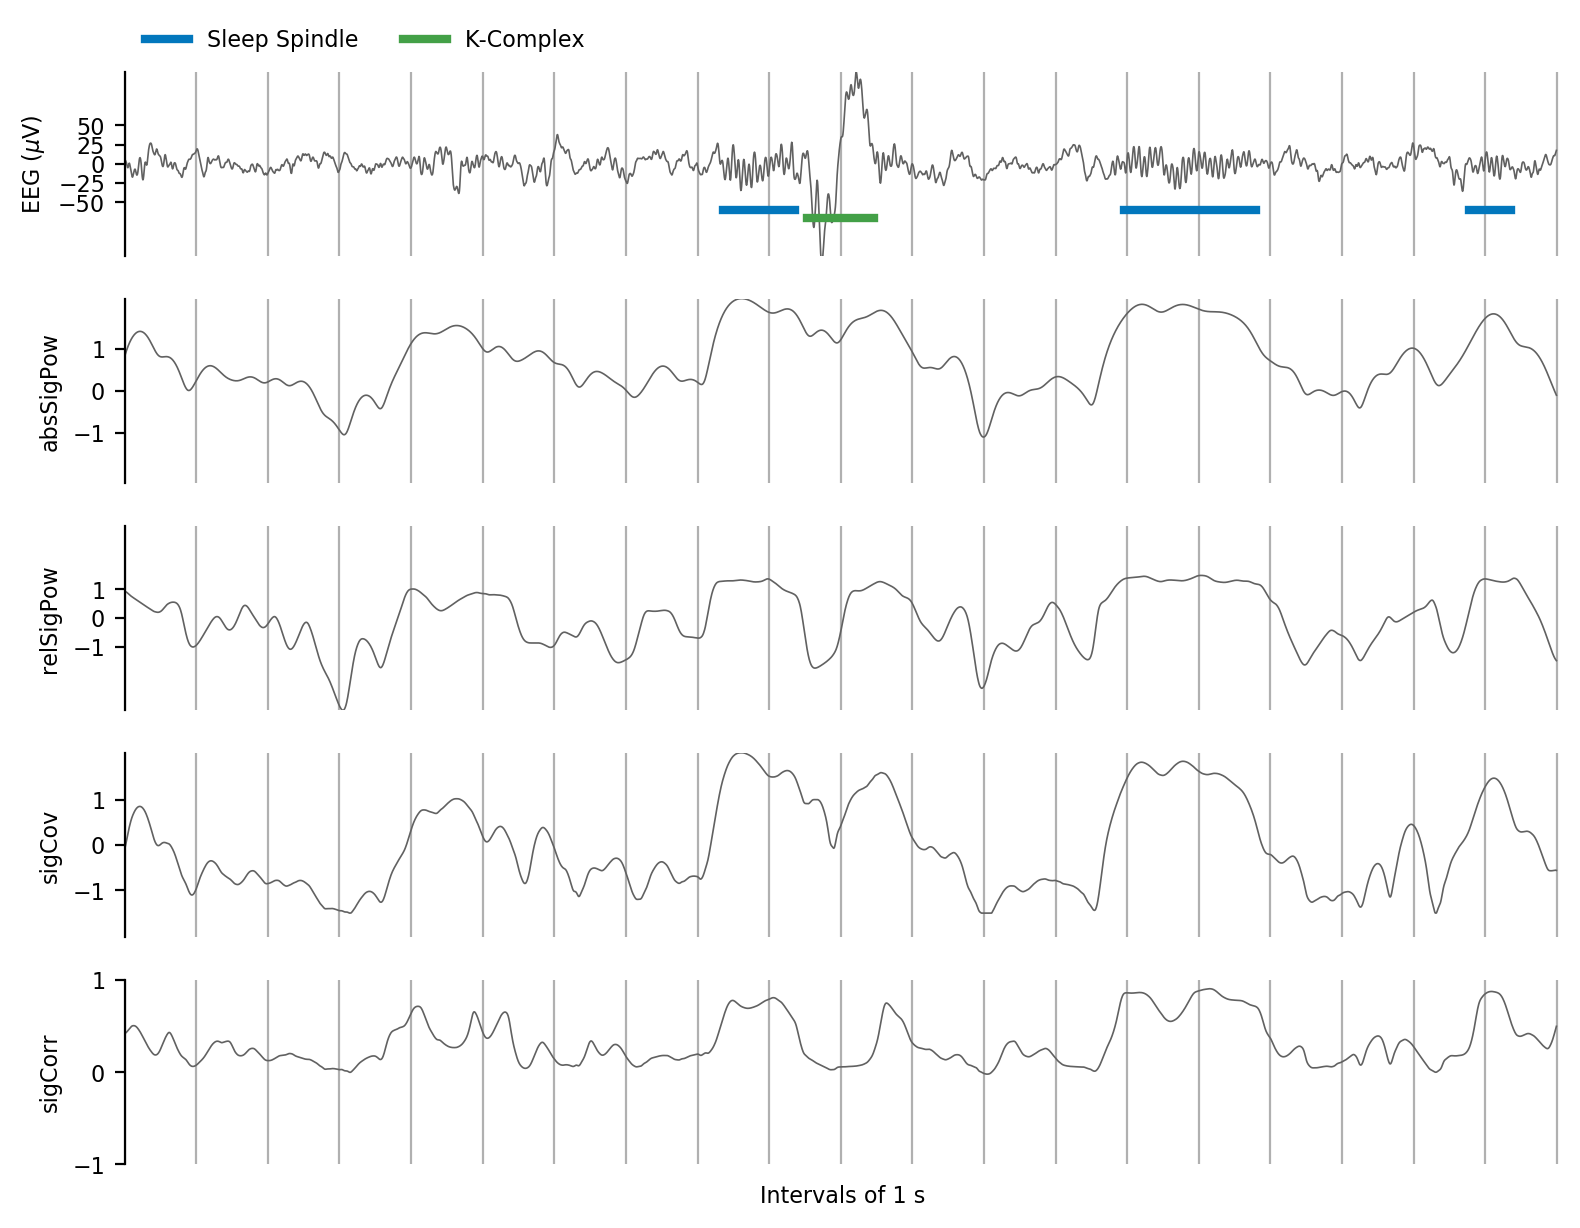

In [20]:
tf.reset_default_graph()
expert_feats_tf = a7_layer_tf(
    segment_signal.reshape(1, -1), fs,
    window_duration=0.5,
    sigma_lowcut=11,
    sigma_highcut=16,
    use_log_absSigPow=True,
    use_log_relSigPow=True,
    use_log_sigCov=True,
    use_zscore_relSigPow=True,
    use_zscore_sigCov=True,
    use_zscore_sigCorr=False,
    dispersion_mode="std"
)
with tf.Session() as sess:
    expert_feats = sess.run(expert_feats_tf)


feats_names = ['absSigPow', 'relSigPow', 'sigCov', 'sigCorr']

fig, axes = plt.subplots(5, 1, dpi=200, figsize=(8, 6), sharex=True)

ax = axes[0]
ax = draw_signal(ax, segment_signal, xlabel="")
ax = draw_stamps(ax, segment_stamps_ss, segment_stamps_kc)
ax.legend(loc='lower left', bbox_to_anchor=(0,1), ncol=2, fontsize=viz.FONTSIZE_GENERAL, frameon=False)

for i in range(4):
    ax = axes[i+1]
    this_feat = expert_feats[..., i].flatten()
    this_name = feats_names[i]
    y_max = max(np.abs(this_feat).max(), 1)
    y_min = -y_max
    if i < 3:
        xlabel = ""
    else:
        xlabel = "Intervals of 1 s"
    ax = draw_signal(ax, this_feat, y_min=y_min, y_max=y_max, yticks=[-1, 0, 1], ylabel=this_name, xlabel=xlabel)

plt.tight_layout()
plt.show()